# Introduction

So what we have is 1 second long samples of people saying some specific words, recorded with a large variety of devices in diverse conditions to get as many different types of input samples as possible. We aim to train a deep learning classifier in order to correctly classify the words in to the correct label. The data has been taken from the Kaggle competition [TensorFlow Speech Recognition Challenge]('https:\\\\www.kaggle.com\\competitions\\tensorflow-speech-recognition-challenge\\overview').

However we deviate slightly from the competition guidelines and rather predict the correct labels for all the classes. Moreoever, we restrict our overall classification to only 10 classes - "zero", "one", "two", ... , "nine".

# Extraction of data

At first we extract the .7z archives.

In [1]:
import os
cwd = os.getcwd()

In [ ]:
%pip install py7zr
import py7zr
archive=py7zr.SevenZipFile('../input/tensorflow-speech-recognition-challenge/train.7z', mode='r')
archive.extractall(path=cwd)
archive.close()
# archive=py7zr.SevenZipFile('..\\input\\tensorflow-speech-recognition-challenge\\test.7z', mode='r')
# archive.extractall(path="\\kaggle\\working")
# archive.close()

# Imports

In [4]:
import sys
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio

from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as scores

In [5]:
# torch imports

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchaudio
import torchmetrics
from torchinfo import summary

import librosa

# File structure

Below are the categories for which we have audio samples, and then after that will be number of audio sample for each class

In [6]:
CLASSES = [
    "zero",
    "one",
    "two",
    "three",
    "four",
    "five",
    "six",
    "seven",
    "eight",
    "nine"
]

for sound in CLASSES:
    path = os.path.join(cwd, "train", "audio", sound)
    print(f"Number of samples in {sound} is {len(os.listdir(path))}")

Number of samples in zero is 2376
Number of samples in one is 2370
Number of samples in two is 2373
Number of samples in three is 2356
Number of samples in four is 2372
Number of samples in five is 2357
Number of samples in six is 2369
Number of samples in seven is 2377
Number of samples in eight is 2352
Number of samples in nine is 2364


# Preparing the dataset

## Gathering the train, test and val samples


In the zipped files, we have the files `testing_list.txt` and `validation_list.txt` which contains the full file path of the audio files which are to be in training and validation sets respectively. So we read those paths and store them. 

In [7]:
test = pd.DataFrame(
    open(os.path.join(cwd, "train", "testing_list.txt"), 'r').readlines(),
).apply(lambda row: os.path.join(cwd, "train", "audio", os.sep.join(row[0].split('\n')[0].split('/'))), axis=1)
validation = pd.DataFrame(
    open(os.path.join(cwd, "train", "validation_list.txt"), 'r').readlines(),
).apply(lambda row: os.path.join(cwd, "train", "audio", os.sep.join(row[0].split('\n')[0].split('/'))), axis=1)

Since we have the test and val sets, we should also have the train set as well

In [8]:
all_files = set(glob.glob(os.path.join(cwd, "train", "audio", "*", "*.wav")))
train = pd.Series(
    list(all_files - set(test.values) - set(validation.values))
)

We run into a problem here: each of train, val, test contains unwanted classes. We remove them.

In [9]:
def remove_unwanted_classes(dataset, classes):
    return dataset[dataset.apply(lambda x: True if x.split(os.sep)[5] in classes else False)].reset_index(drop=True)

train = remove_unwanted_classes(train, CLASSES)
validation = remove_unwanted_classes(validation, CLASSES)
test = remove_unwanted_classes(test, CLASSES)

We see the number of samples from each category in each of the train, val and test sets and also the total number of samples in each of them.

In [10]:
print(
    pd.DataFrame(
        {
            '#train': pd.concat([train.apply(lambda x: x.split(os.sep)[5]).value_counts(), pd.Series({'total': len(train)})]),
            '#validation': pd.concat([validation.apply(lambda x: x.split(os.sep)[5]).value_counts(), pd.Series({'total': len(validation)})]),
            '#test': pd.concat([test.apply(lambda x: x.split(os.sep)[5]).value_counts(), pd.Series({'total': len(test)})]),
        },
        index = CLASSES + ['total']
    )
)

       #train  #validation  #test
zero     1866          260    250
one      1892          230    248
two      1873          236    264
three    1841          248    267
four     1839          280    253
five     1844          242    271
six      1863          262    244
seven    1875          263    239
eight    1852          243    257
nine     1875          230    259
total   18620         2494   2552


Finally we we need to make a train, test, and val dataset, with the file path and the corressponding labels. We also will need to create a `CLASS_MAPPING` where we map the integer labels to the actual labels.

In [11]:
# maps class to label
LABEL_MAPPING = {text_label: int_label for int_label, text_label in enumerate(CLASSES)}
# maps label to clsss
CLASS_MAPPING = {int_label: text_label for int_label, text_label in enumerate(CLASSES)}

In [12]:
def convert_to_annoted_dataframe(dataset, label_mapping):
    dataset = pd.DataFrame(dataset, columns=['path'])
    dataset['class'] = dataset['path'].apply(lambda p: p.split(os.sep)[5])
    dataset['label'] = dataset['class'].map(LABEL_MAPPING)
    return dataset

train = convert_to_annoted_dataframe(train, LABEL_MAPPING)
validation = convert_to_annoted_dataframe(validation, LABEL_MAPPING)
test = convert_to_annoted_dataframe(test, LABEL_MAPPING)

## Creating the dataset

In [13]:
# constants

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
AUDIO_DIR = os.path.join(cwd, "train", "audio")
SAMPLE_RATE = 16000 # try 8000 later
NUM_SAMPLES = 16000

In [14]:
class SpeechData(Dataset):
    
    def __init__(
        self, 
        annotations_file, 
        audio_dir, 
        transform=None, 
        target_sample_rate=16000,
        num_samples=16000,
        device='cpu'
    ):
        """
        annotations_file: dataframe containing the file paths and the labels of whichever dataset we are loading
        audio_dir: directory where the audio files are located (assuming that _background_noise_ has been deleted)
        transforms: transformations to be applied on to the audio
        target_sample_rate: target sample rate of all the audio
        """
        self.annotations_file = annotations_file
        self.audio_dir = audio_dir
        try:
            self.transform = transform.to(device)
        except:
            self.transform = transform
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.device = device
        
    def __len__(self):
        """
        returns: len(data)
        """
        return len(self.annotations_file)
    
    def __getitem__(self, index):
        """
        returns: data[index] -> torch.tensor(signal, label)
        """
        # getting the signal and the sample_rate
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sample_rate = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)

        # resample (not necessary, all at 16k)
        # stereo to mono (not necessary)

        # resize if necessary
        signal = self._resize_if_necessary(signal)

        # transforming the signal
        if self.transform:
            signal = self.transform(signal)
        
        return signal, label
    
    def _get_audio_sample_path(self, index):
        return self.annotations_file.loc[index, 'path']
    
    def _get_audio_sample_label(self, index):
        return self.annotations_file.loc[index, 'label']

    def _resize_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal > self.num_samples:
            signal = signal[:, :self.num_samples]
        elif length_signal < self.num_samples:
            num_missing = self.num_samples - length_signal
            last_dim_padding = (0, num_missing)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

In [21]:
# initialising all the transforms that we would use

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64,
)
audio = SpeechData(
    train, 
    AUDIO_DIR, 
    target_sample_rate=SAMPLE_RATE,
    num_samples = NUM_SAMPLES,
)
print(f"There are {len(audio)} samples")

signal, label = audio[1]
print(f"Signal shape: {signal.shape} # (num_channels, num_samples)")
print(f"Label: {label}")
print(f"Class: {CLASS_MAPPING[label]}")

There are 18620 samples
Signal shape: torch.Size([1, 16000]) # (num_channels, num_samples)
Label: 9
Class: nine


## Audio files, signals, channels and sample rates

The audio files are all 1 second long and are in the *.int* format. The audio signals that `torchaudio` returns us are `tensors` in the shape of `(num_channels, num_samples)`.  

- `num_channels` will be 1 or 2 depending on whether the audio is **mono** or **stereo**. In case it is in stereo, we will downmix it to a mono channel. Generally we do this by taking the average of the samples in both the channels at the same time stamps.  
- `num_samples` is the total number of samples present in the audio.  
- `sample_rate` is the number of samples in 1 second of the audio. Since in our data we have only 1 second long audio, our `num_samples` = `sample_rate`. Generally we have a target sample rate that we will use with `torchaudio`. In order to get to that target sample rate we may have to resample the audio if necessary.  

In our dataset, all our audio are mono and sampled at 16000 samples per second. This means we dont have to unnecessarily work on resizing or resampling.

In [19]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()
    font = {
    'family': 'serif',
    'color':  'black',
    'weight': 'normal',
    'size': 18
    }
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1, figsize=(8, 4))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    axes[0].set_title('Waveform', fontdict=font)
    axes[0].set_xlabel('Time', fontdict=font)
    plt.show(block=False);


def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    font = {
    'family': 'serif',
    'color':  'black',
    'weight': 'normal',
    'size': 18
    }
    fig, axs = plt.subplots(1, 1, figsize=(8, 4))
    axs.set_title(title or "Spectrogram (db)", fontdict=font)
    axs.set_ylabel(ylabel, fontdict=font)
    axs.set_xlabel("frame", fontdict=font)
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

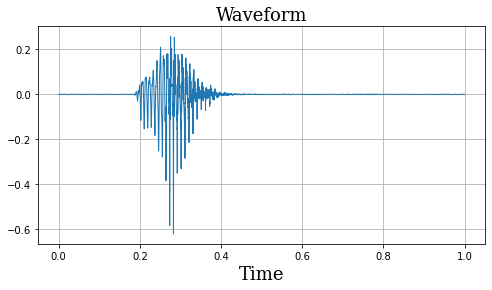

In [23]:
plot_waveform(signal, SAMPLE_RATE)

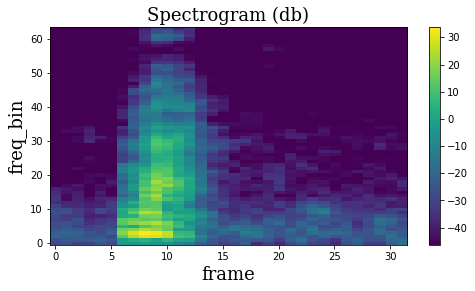

In [20]:
plot_spectrogram(signal[0])

## Visualising waveform and mel spectrogram side by side

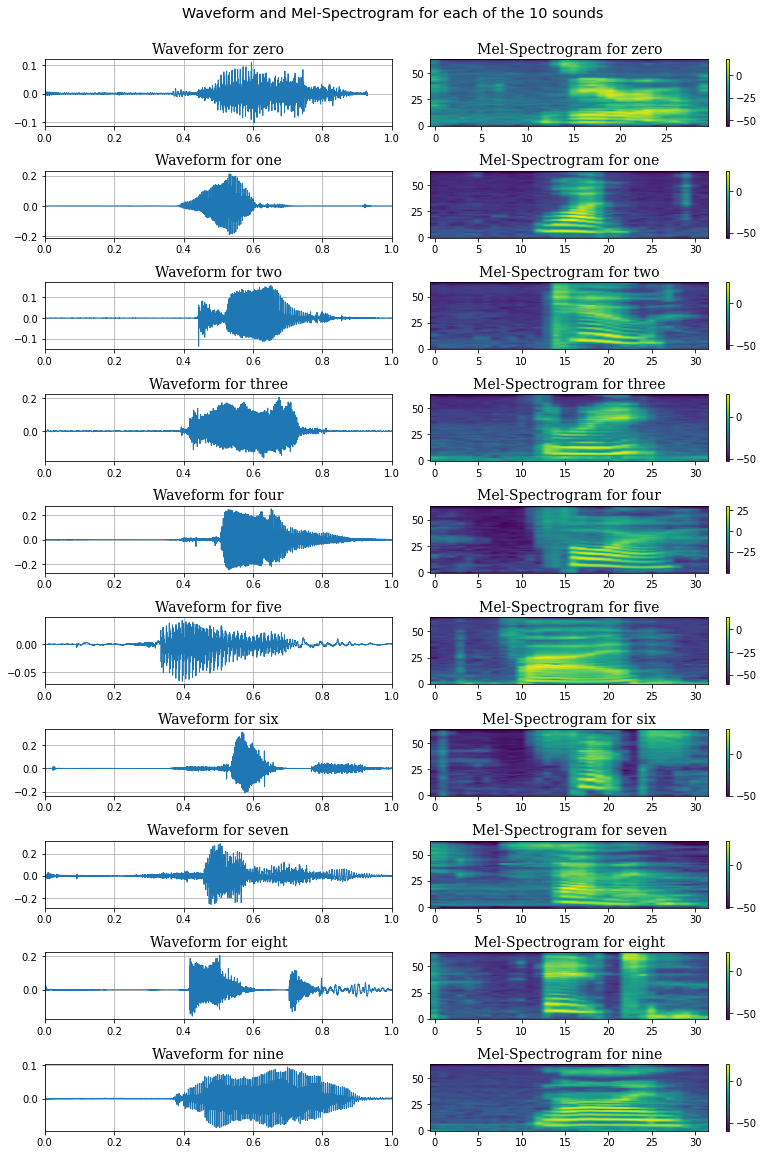

In [26]:
# selected files, where the audio files have sufficient clarity
vis_paths = {
    'zero': '6adb8ad9_nohash_0.wav',
    'one': '03c96658_nohash_0.wav',
    'two': '03c96658_nohash_0.wav',
    'three': '02e85b60_nohash_0.wav',
    'four': '03c96658_nohash_0.wav',
    'five': '7b301939_nohash_0.wav',
    'six': '03c96658_nohash_0.wav',
    'seven': '8a5acefd_nohash_0.wav',
    'eight': '03c96658_nohash_0.wav',
    'nine': '1a6eca98_nohash_0.wav',
}
# complete path to all the candidate files
path_to_candidate_samples = [os.path.join(cwd, "train", "audio", s, f) for s, f in vis_paths.items()]

figure, axs = plt.subplots(10, 2, figsize=(11, 16))
wf_axs = axs[:, 0]
spec_axs = axs[:, 1]

font = {
    'family': 'serif',
    'color':  'black',
    'weight': 'normal',
    'size': 14
}
st = figure.suptitle("Waveform and Mel-Spectrogram for each of the 10 sounds", fontsize="x-large")

for ax, sample in zip(axs, path_to_candidate_samples):
    # plotting the waveform
    signal, sr = torchaudio.load(sample)
    waveform = signal.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    ax[0].plot(time_axis, waveform[0], linewidth=1)
    ax[0].grid(True)
    ax[0].set_title(f'Waveform for {sample.split(os.sep)[5]}', fontdict=font)
    ax[0].set_xlim(0,1)

    # plotting the mel-spec
    specgram = mel_spectrogram(signal)

    ax[1].set_title(f'Mel-Spectrogram for {sample.split(os.sep)[5]}', fontdict=font)
    im = ax[1].imshow(librosa.power_to_db(specgram[0]), origin="lower", aspect="auto")
    figure.colorbar(im, ax=ax[1])

st.set_y(1)
figure.tight_layout()
plt.show();

Seeing that different numbers do have different mel-spectrograms, it makes sense in using CNN's to perform the classification. As a test, just lets run the model with a small subset of the data - say around $200$ data points, which is $\approx 20$ audio files for each of the classes.

# Models

In [28]:
# some more constants

BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 0.001
NUM_WORKERS = 2

## Base model architecture

Our base model will be a VGG-ish architecture which consists of:  
$$\texttt{inputs }\rightarrow\texttt{ 4 conv blocks }\rightarrow\texttt{ Flatten }\rightarrow\texttt{ Linear }\rightarrow\texttt{ Softmax }$$  
where each `conv block` is  
$$\texttt{Conv2d }\rightarrow\texttt{ ReLU }\rightarrow\texttt{ Maxpool2d }$$

In [30]:
class convblock(nn.Module):
    def __init__(self, insize, outsize, kernel_size, stride, padding):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(insize, outsize, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    def forward(self, x):
        return self.layer(x)

class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = convblock(1, 16, 3, 1, 2)
        self.conv2 = convblock(16, 32, 3, 1, 2)
        self.conv3 = convblock(32, 64, 3, 1, 2)
        self.conv4 = convblock(64, 128, 3, 1, 2)
        
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(1920, 10)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions
    
# model
basemodel = BaseModel().to(DEVICE)
print(summary(basemodel, (BATCH_SIZE, 1, 64, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
BaseModel                                [128, 10]                 --
├─convblock: 1-1                         [128, 16, 33, 17]         --
│    └─Sequential: 2-1                   [128, 16, 33, 17]         --
│    │    └─Conv2d: 3-1                  [128, 16, 66, 34]         160
│    │    └─ReLU: 3-2                    [128, 16, 66, 34]         --
│    │    └─MaxPool2d: 3-3               [128, 16, 33, 17]         --
├─convblock: 1-2                         [128, 32, 17, 9]          --
│    └─Sequential: 2-2                   [128, 32, 17, 9]          --
│    │    └─Conv2d: 3-4                  [128, 32, 35, 19]         4,640
│    │    └─ReLU: 3-5                    [128, 32, 35, 19]         --
│    │    └─MaxPool2d: 3-6               [128, 32, 17, 9]          --
├─convblock: 1-3                         [128, 64, 9, 5]           --
│    └─Sequential: 2-3                   [128, 64, 9, 5]           --
│    │    └

## CRNN Model

Next we have a CRNN model, where we run the input tensor through 3 conv blocks, of composition:
$$\texttt{Conv1d }\rightarrow\texttt{ Batchnorm1d }\rightarrow\texttt{ ReLU }\rightarrow\texttt{ Maxpool1d}$$  
We feed the output from this to a $\texttt{LSTM}\rightarrow\texttt{ Dropout}$ layer. Then we flatten it and pass it into the following sequence of fully connected layers:
$$\rightarrow\texttt{ Linear }\rightarrow\texttt{ ReLU }\rightarrow\texttt{ Linear }\rightarrow\texttt{ Softmax}$$

In [50]:
class convbloc(nn.Module):
    def __init__(self, insize, outsize, kernels, stride, padding=0):
        super().__init__()
        self.bloc = nn.Sequential(
            nn.Conv1d(insize, outsize, kernel_size=kernels, stride=stride, padding=padding),
            nn.BatchNorm1d(outsize, momentum=0.9),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
    def forward(self, x):
        x = self.bloc(x)
        return x

class CRNN(nn.Module):
    
    def __init__(self):
        super(CRNN, self).__init__()
        self.conv1 = convbloc(64, 128, kernels=5, stride=1, padding=2)
        self.conv2 = convbloc(128, 128, kernels=5, stride=1, padding=2)
        self.conv3 = convbloc(128, 256, kernels=5, stride=1, padding=2)
        
        self.lstm = nn.LSTM(input_size=4, hidden_size=96, batch_first=True)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Sequential(
            nn.Linear(256*96, 64), 
            nn.ReLU()
        )
        self.linear2 = nn.Linear(64, 10)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input_tensor):
        x = self.conv1(input_tensor.squeeze(1))
        x = self.conv2(x)
        x = self.conv3(x)
        x, *_ = self.lstm(x)
        x = nn.Dropout(p=0.4)(x)
        x = self.flatten(x)
        x = self.linear1(x)
        logits = self.linear2(x)
        predictions = self.softmax(logits)
        return predictions
        
crnn = CRNN().to(DEVICE)
print(summary(crnn, (BATCH_SIZE, 64, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
CRNN                                     [128, 10]                 --
├─convbloc: 1-1                          [128, 128, 16]            --
│    └─Sequential: 2-1                   [128, 128, 16]            --
│    │    └─Conv1d: 3-1                  [128, 128, 32]            41,088
│    │    └─ReLU: 3-2                    [128, 128, 32]            --
│    │    └─BatchNorm1d: 3-3             [128, 128, 32]            256
│    │    └─MaxPool1d: 3-4               [128, 128, 16]            --
├─convbloc: 1-2                          [128, 128, 8]             --
│    └─Sequential: 2-2                   [128, 128, 8]             --
│    │    └─Conv1d: 3-5                  [128, 128, 16]            82,048
│    │    └─ReLU: 3-6                    [128, 128, 16]            --
│    │    └─BatchNorm1d: 3-7             [128, 128, 16]            256
│    │    └─MaxPool1d: 3-8               [128, 128, 8]             --
├─con

## CNN-Resnet like model

In this model we have the following architecture:
$$\texttt{Conv }\rightarrow\texttt{ Dropout }\rightarrow\texttt{ Conv (twice) }\rightarrow\texttt{ Res }\rightarrow\texttt{ Linear }\rightarrow\texttt{ Softmax}$$  
where the individual blocks are:
$$\texttt{Conv }=\texttt{ Conv2d }\rightarrow\texttt{ Batchnorm2d }\rightarrow\texttt{ LeakyReLU }\rightarrow\texttt{ Maxpool2d}$$
$$\texttt{Res }=\texttt{ Batchnorm2d }\rightarrow\texttt{ Conv2d }\rightarrow\texttt{ PReLU}\rightarrow\texttt{ Flatten}$$

In [34]:
# CNN-Res

class ConvRes(nn.Module):
    def __init__(self, insize, outsize):
        super().__init__()
        drate = .3
        self.layer = nn.Sequential(
            nn.BatchNorm2d(insize),
            nn.Conv2d(insize, outsize, kernel_size=2, padding=2),
            nn.PReLU(),
        )
    def forward(self, x):
        return self.layer(x)
    
class ConvCNN(nn.Module):
    def __init__(
        self, 
        insize, 
        outsize, 
        kernel_size, 
        padding=2, 
        pool=2, 
        avg=True
    ):
        super().__init__()
        self.avg = avg
        self.layer = nn.Sequential(
            nn.Conv2d(insize, outsize, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(outsize),
            nn.LeakyReLU(),
            nn.MaxPool2d(pool, pool),
        )
        self.avgpool = nn.AvgPool2d(pool, pool)
        
    def forward(self, x):
        x = self.layer(x)
        if self.avg:
            x = self.avgpool(x)
        return x
    
class CNN_Res(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
        self.cnn1 = ConvCNN(1, 32, kernel_size=3, pool=4, avg=False)
        self.cnn2 = ConvCNN(32, 32, kernel_size=5, pool=2, avg=True)
        self.cnn3 = ConvCNN(32, 32, kernel_size=3, pool=2, avg=True)
        
        self.res1 = ConvRes(32, 64)
        
        self.features = nn.Sequential(
            self.cnn1,
            nn.Dropout(p=0.3),
            self.cnn2,
            self.cnn3,
            self.res1,
        )
        
        self.linear = nn.Linear(1024, 10)
        
    def forward(self, x):
        x = self.features(x)
        x = nn.Flatten()(x)
        logits = self.linear(x)
        predictions = nn.Softmax(dim=1)(logits)
        return predictions

cnnres = CNN_Res()
summary(cnnres, (BATCH_SIZE, 1, 64, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Res                                  [128, 10]                 --
├─Sequential: 1-1                        [128, 64, 4, 4]           --
│    └─ConvCNN: 2-1                      [128, 32, 16, 8]          --
│    │    └─Sequential: 3-1              [128, 32, 16, 8]          384
│    └─Dropout: 2-2                      [128, 32, 16, 8]          --
│    └─ConvCNN: 2-3                      [128, 32, 4, 2]           --
│    │    └─Sequential: 3-2              [128, 32, 8, 4]           25,696
│    │    └─AvgPool2d: 3-3               [128, 32, 4, 2]           --
│    └─ConvCNN: 2-4                      [128, 32, 1, 1]           --
│    │    └─Sequential: 3-4              [128, 32, 3, 2]           9,312
│    │    └─AvgPool2d: 3-5               [128, 32, 1, 1]           --
│    └─ConvRes: 2-5                      [128, 64, 4, 4]           --
│    │    └─Sequential: 3-6              [128, 64, 4, 4]           8,321
├─Li

# Training

## Dataloaders

Below we create the data loader, and instantiate the data loader objects corresponding to train, test, and val with the necessary transforms.

In [35]:
# creates the actual data loader
def create_data_loader(train_data, batch_size, **kwargs):
    train_dataloader = DataLoader(train_data, batch_size=batch_size, **kwargs)
    return train_dataloader

In [36]:
# basic training procedure

# instantiating dataset object
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64,
)

# get the dataset
train_audio = SpeechData(
    train, 
    AUDIO_DIR, 
    target_sample_rate=SAMPLE_RATE,
    transform=mel_spectrogram,
    num_samples=NUM_SAMPLES,
    device=DEVICE
)

val_audio = SpeechData(
    validation,
    AUDIO_DIR,
    target_sample_rate=SAMPLE_RATE,
    transform=mel_spectrogram,
    num_samples=NUM_SAMPLES,
    device=DEVICE
)
test_audio = SpeechData(
    test,
    AUDIO_DIR,
    target_sample_rate=SAMPLE_RATE,
    transform=mel_spectrogram,
    num_samples=NUM_SAMPLES,
    device=DEVICE
)

# get the dataloader
train_dataloader = create_data_loader(
    train_audio, 
    batch_size=BATCH_SIZE,
    shuffle=True,
)
val_dataloader = create_data_loader(
    val_audio, 
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_dataloader = create_data_loader(
    test_audio, 
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [37]:
print("Train")
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}\n")

print("Validation")
val_features, val_labels = next(iter(val_dataloader))
print(f"Feature batch shape: {val_features.size()}")
print(f"Labels batch shape: {val_labels.size()}\n")

print("Test")
test_features, test_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}\n")

Train
Feature batch shape: torch.Size([128, 1, 64, 32])
Labels batch shape: torch.Size([128])

Validation
Feature batch shape: torch.Size([128, 1, 64, 32])
Labels batch shape: torch.Size([128])

Test
Feature batch shape: torch.Size([128, 1, 64, 32])
Labels batch shape: torch.Size([128])



## Training Loop in $\texttt{PyTorch}$

Below we have the training loop. `train_network` is the primary function which calls `train` with the model and other necessary parameters. At every epoch, `train_single_epoch` is called to train the model and `validate_single_epoch` is called to validate the model for that epoch. The results are displayed accordingly.

In [64]:
def train_single_epoch(model, data_loader, loss_fn, optimiser, device, epoch):
    running_loss = torch.tensor([], dtype=torch.float32).to(device)
    running_acc = torch.tensor([], dtype=torch.float32).to(device)
    loop = tqdm(data_loader, unit=" batch")
    
    for inputs, targets in loop:
        
        loop.set_description(f"Epoch = {epoch}")
        inputs, targets = inputs.to(device), targets.to(device)

        # calculate loss
        output = model(inputs)
        loss = loss_fn(output, targets)
        
        # calculating multiclass accuracy
        predictions = output.argmax(dim=1, keepdim=True).squeeze()
        accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10, top_k=1).to(DEVICE)(predictions, targets)

        # backpropagate error and update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        running_loss = torch.cat((running_loss, loss.unsqueeze(0)))
        running_acc = torch.cat((running_acc, accuracy.unsqueeze(0)))
        loop.set_postfix_str(f"Loss = {loss.item():.4f}, Accuracy = {100. * accuracy:.2f}")
        
    return running_loss, running_acc

def validate_single_epoch(model, data_loader, loss_fn, optimiser, device):
    running_loss = torch.tensor([], dtype=torch.float32).to(device)
    running_acc = torch.tensor([], dtype=torch.float32).to(device)
    
    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # calculate loss
        output = model(inputs)
        loss = loss_fn(output, targets)
        
        # calculating multiclass accuracy
        predictions = output.argmax(dim=1, keepdim=True).squeeze()
        accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10, top_k=1).to(DEVICE)(predictions, targets)
        
        running_loss = torch.cat((running_loss, loss.unsqueeze(0)))
        running_acc = torch.cat((running_acc, accuracy.unsqueeze(0)))
        
    return running_loss, running_acc

def train(model, train, val, loss_fn, optimiser, device, epochs):
    """
    In this function we iterate over the range of epochs. In each run, we go through one epoch of training.
    There are multiple things that we should do in this function like:
    - calculating validation loss
    """
    train_loss = torch.tensor([], dtype=torch.float32).to(device)
    train_acc = torch.tensor([], dtype=torch.float32).to(device)
    
    val_loss = torch.tensor([], dtype=torch.float32).to(device)
    val_acc = torch.tensor([], dtype=torch.float32).to(device)
    
    print("Starting training...")
    for i in range(epochs):
        
        model.train(True)
        loss, acc = train_single_epoch(model, train, loss_fn, optimiser, device, i+1)
        print("Training")
        print(f"Average loss = {torch.mean(loss):.4f}, Average accuracy = {torch.mean(acc)*100:.2f}\n")
        train_loss = torch.cat((train_loss, torch.mean(loss).unsqueeze(0)))
        train_acc = torch.cat((train_acc, torch.mean(acc).unsqueeze(0)))
        
        print("Validation")
        model.train(False)
        loss, acc = validate_single_epoch(model, val, loss_fn, optimiser, device)
        print(f"Average loss = {torch.mean(loss):.4f}, Average accuracy = {torch.mean(acc)*100:.2f}\n")
        val_loss = torch.cat((val_loss, torch.mean(loss).unsqueeze(0)))
        val_acc = torch.cat((val_acc, torch.mean(acc).unsqueeze(0)))
        
    print("Finished training")

In [56]:
def train_network(model, epochs):
    # loss function + optimiser
    loss_fn = nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(
        model.parameters(),
        lr = LEARNING_RATE
    )
    train(model, train_dataloader, val_dataloader, loss_fn, optimiser, DEVICE, epochs)

# Results

In [ ]:
train_network(cnnres, 5)

In [ ]:
train_network(crnn, 10)